In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixture, GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

2023.06.07


In [124]:
from scipy.stats import spearmanr
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import copy

# EDA

## Load data

### Integrate data

**Download processed data**
```
!wget  -O ./data/HSPC/rna.h5ad https://figshare.com/ndownloader/files/40064320
!wget  -O ./data/HSPC/atac.h5ad https://figshare.com/ndownloader/files/40064311
```

**Download raw data**
```
!curl  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6403nnn/GSM6403410/suppl/GSM6403410_3423-MV-2_gex_possorted_bam_ICXFB.loom.gz --output ./data/HSPC/GSM6403410_3423-MV-2_gex_possorted_bam_ICXFB.loom.gz

!gunzip GSM6403410_3423-MV-2_gex_possorted_bam_ICXFB.loom.gz
!curl https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6403nnn/GSM6403411/suppl/GSM6403411_3423-MV-2_atac_fragments.tsv.gz --output ./data/HSPC/GSM6403411_3423-MV-2_atac_fragments.tsv.gz 
!curl https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6403nnn/GSM6403411/suppl/GSM6403411_3423-MV-2_atac_fragments.tsv.gz.tbi.gz --output ./data/HSPC/GSM6403411_3423-MV-2_atac_fragments.tsv.gz.tbi.gz
!curl https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6403nnn/GSM6403411/suppl/GSM6403411_3423-MV-2_atac_peak_annotation.tsv.gz --output ./data/HSPC/GSM6403411_3423-MV-2_atac_peak_annotation.tsv.gz

%cd data/HSPC/
!gunzip GSM6403411_3423-MV-2_atac_fragments.tsv.gz 
!gunzip GSM6403411_3423-MV-2_atac_fragments.tsv.gz.tbi.gz
!gunzip GSM6403411_3423-MV-2_atac_peak_annotation.tsv.gz
%cd /home/mffang/workspace/Poisson-regression
```

**Load RNA data**
```
raw_rna = alldata = sc.read('data/HSPC/GSM6403410_3423-MV-2_gex_possorted_bam_ICXFB.loom')
rna = sc.read('data/HSPC/rna.h5ad')
atac = sc.read('data/HSPC/atac.h5ad')

ID = np.array([cell[-17:-1] for cell in raw_rna.obs_names],dtype=str)

cell_idx = np.array([ np.where(ID==obs_name[:-2])[0][0] for obs_name in rna.obs_names],dtype=int)
alldata = raw_rna[cell_idx]
alldata.layers['spliced'] = raw_rna.layers['spliced'][cell_idx].copy()
alldata.layers['unspliced'] = raw_rna.layers['unspliced'][cell_idx].copy()
alldata.obs = rna.obs
alldata.obsm = rna.obsm
```

**Load ATAC data**

```
import scipy.io
import pandas as pd
import loompy

# Load the barcode feature matrix from the MTX file
matrix_file = "data/HSPC/GSE209878_3423-MV-2_matrix.mtx"
matrix = scipy.io.mmread(matrix_file)

# Load the barcode information from the barcode TSV file
barcode_file = "data/HSPC/GSE209878_3423-MV-2_barcodes.tsv"
barcode_df = pd.read_csv(barcode_file, delimiter='\t', header=None, names=["barcode"])
barcode_df

# Load the feature information from the feature TSV file
feature_file = "data/HSPC/GSE209878_3423-MV-2_features.tsv"
feature_df = pd.read_csv(feature_file, delimiter='\t', header=None, names=["ensembl_id", "gene_name", "type", "chromosome", "start", "end"])
# Filter the feature information to extract "Peaks"
peaks_df = feature_df[feature_df['type'] == "Peaks"]

# Get the indices of the "Peaks" features in the barcode feature matrix
peaks_indices = [feature_df.index.get_loc(idx) for idx in peaks_df.index]

# Extract the count matrix of "Peaks" from the barcode feature matrix
peaks_matrix = matrix.tocsr()[peaks_indices, :]

# Read the peak annotation file
peak_annotation_file = "data/HSPC/GSM6403411_3423-MV-2_atac_peak_annotation.tsv"
peak_annotation_df = pd.read_csv(peak_annotation_file, delimiter='\t')

# Create a dictionary to map coordinates to gene names
coord_to_gene = {}
for _, row in peak_annotation_df.iterrows():
    coord = (row['chrom'], row['start'], row['end'])
    gene_name = row['gene']
    coord_to_gene[coord] = gene_name

# Get the gene names for each entry in peaks_df
gene_names = []
for _, row in peaks_df.iterrows():
    coord = (row['chromosome'], row['start'], row['end'])
    gene_name = coord_to_gene.get(coord, "")
    gene_names.append(gene_name)

# Add the "gene_name" column to peaks_df
peaks_df.loc[:, 'gene_name'] = gene_names

# Print the updated peaks_df
print(peaks_df)


atac_matrix = peaks_matrix.transpose().toarray()

cell_idx = np.array([ np.where(barcode_df['barcode']==obs_name)[0][0] for obs_name in alldata.obs_names],dtype=int)

share_genes = alldata.var_names[alldata.var_names.isin(peaks_df['gene_name'])]
gene_idx = np.array([ np.where(peaks_df['gene_name']==var_name)[0][0] for var_name in share_genes],dtype=int)
gene_idx_alldata = np.array([np.where(alldata.var_names==var_name)[0][0] for var_name in share_genes],dtype=int)

alldata = alldata[:,gene_idx_alldata]
alldata.layers['atac'] = scipy.sparse.csr_matrix(atac_matrix[cell_idx][:,gene_idx])
alldata.write_loom('data/HSPC/HSPC.loom',write_obsm_varm=True)
```

### Load loom file

In [142]:
atac = sc.read('data/HSPC/atac.h5ad')
atac

AnnData object with n_obs × n_vars = 11605 × 1000
    obs: 'n_counts', 'leiden'
    layers: 'Mc'
    obsp: 'connectivities'

In [5]:
alldata=sc.read('data/HSPC/HSPC.loom',validate=False)
alldata

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11605 × 29943
    obs: 'G2M_score', 'S_score', 'fraction_u', 'initial_size', 'initial_size_spliced', 'initial_size_unspliced', 'leiden', 'n_counts', 'n_genes_by_counts', 'obs_names', 'phase', 'root_prediction', 'total_Ms', 'total_Mu', 'total_counts', 'total_s', 'total_u'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_pca', 'X_umap'
    layers: 'matrix', 'ambiguous', 'atac', 'spliced', 'unspliced'

**Define marker genes and load gene length data**

In [6]:
marker_genes = [g.upper() for g in ['Smim1','Hba-x','Abcg2','Cnn3','Scube2','Klf1','Gata1','Gata2','Cd45',"FLI1"] ]
plot_marker_genes = alldata.var_names[alldata.var_names.isin(marker_genes)]
plot_marker_genes

Index(['CNN3', 'SMIM1', 'SCUBE2', 'FLI1', 'KLF1', 'GATA2', 'ABCG2', 'GATA1'], dtype='object', name='Gene')

In [7]:
gene_length_file = np.loadtxt("data/gg_200525_genome_polyA_cum_3.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0].upper() for gene in gene_length_file])
print(np.sum(alldata.var_names.isin(gene_name)))

29311


**PCA plots and marker gene expresssion**

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


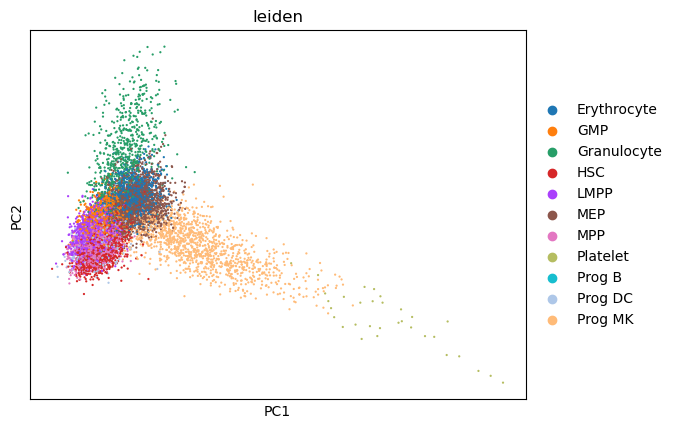

In [8]:
sc.pl.pca(alldata,color='leiden')

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


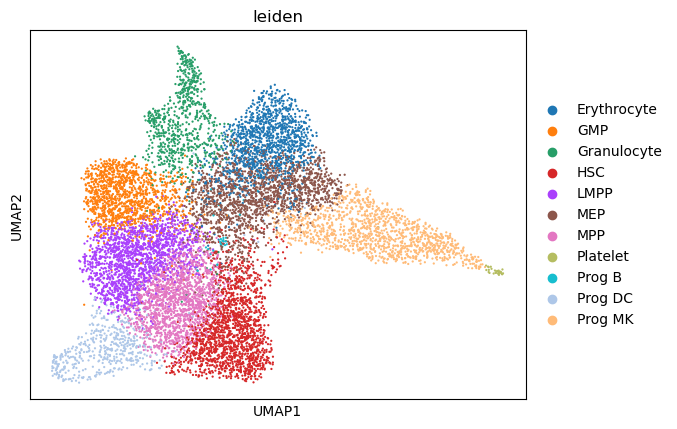

In [9]:
sc.pl.umap(alldata,color='leiden')

## Select cells

In [159]:
Clusters = ['HSC','MEP','Erythrocyte']
cell_idx = alldata.obs["leiden"].isin(Clusters)
adata = alldata[alldata.obs["leiden"].isin(Clusters)]

**Define clusters and cell colors**

In [11]:
clusters = adata.obs["leiden"]
x_umap = adata.obsm['X_umap']

In [12]:
color_palette = ["#dfe3ee","#8b9dc3","#3b5998"]
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Clusters))

cell_colors = np.zeros((adata.n_obs,3))

for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cell_colors[idx] = cmap_cluster(i)[:3]

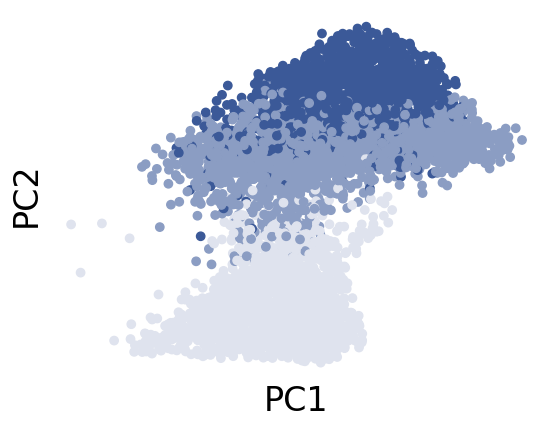

In [14]:
fig, ax = plt.subplots(1,1)
ax.scatter(x_umap[:,0],x_umap[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

## Genes variances

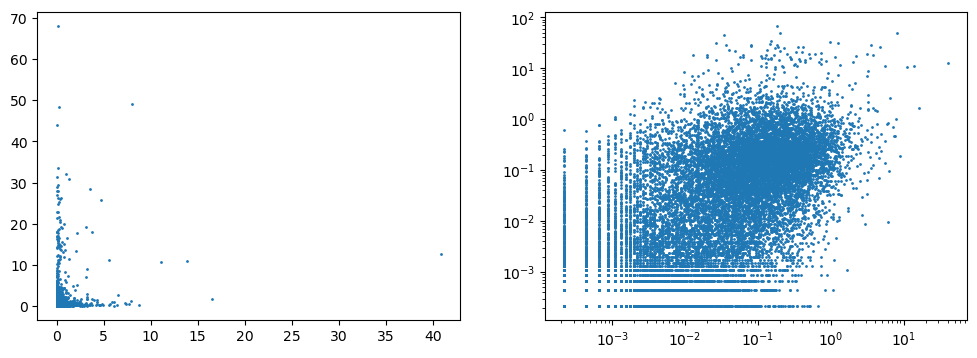

In [15]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [16]:
idx = (adata.layers["atac"].toarray().mean(0) > 0) 
A = adata.layers["atac"][:,idx].toarray()
n,p = A.shape
X = A
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
sa = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total ATAC counts =", str(sa))

idx = (adata.layers["unspliced"].toarray().mean(0) > 0) 
U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))

idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X = U + S
X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total ATAC counts = 0.39107379739839665
s estimated by normalized covariance of total U counts = 0.29156705487436624
s estimated by normalized covariance of total S counts = 0.22822961658250326
s estimated by normalized covariance of total counts = 0.252903151975181
s estimated by total counts = 0.24421748135743013


s estimated by normalized covariance of Poission genes = 0.22822961658250326


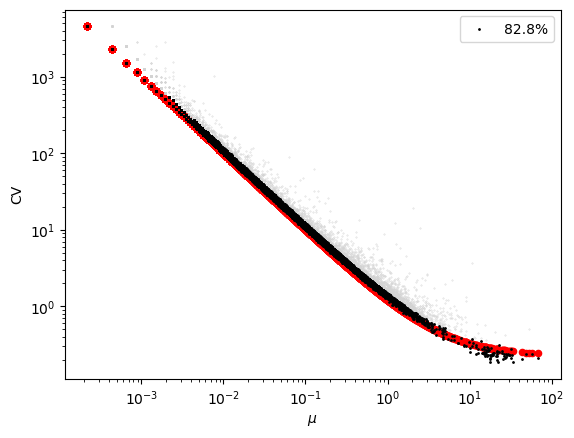

In [18]:
a=1
s=ss

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)

Pgene_mask = (X_mean > 0) & (X_var/(a*X_mean + s*X_mean**2) < 1.2)
Pgenes = adata.var_names[idx][Pgene_mask]

P = (S + U)[:,Pgene_mask]
n,p = P.shape
#P_cov = np.cov(P,rowvar=False)
#P_mean = np.mean(P,axis=0)
#P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
#s = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

plt.scatter(X_bar, a/X_bar + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

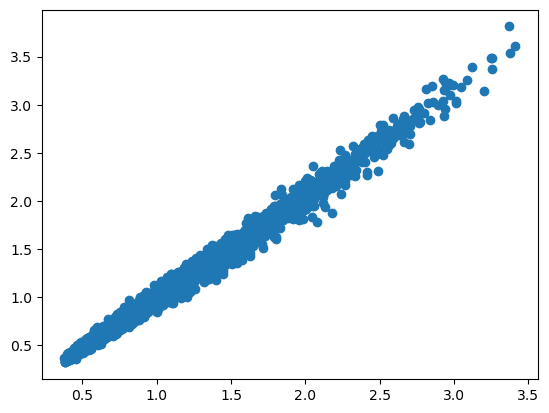

In [19]:
read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.scatter(rd,adata.layers['matrix'].toarray().mean(1)/adata.layers['matrix'].toarray().mean())

## Select genes

In [20]:
var_threshold = 1.2
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.1) & (S_mean > 0.1) \
    & (np.abs(np.log(S_mean/U_mean)) < 4) \
    & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold)
fitted_genes=adata.var_names[fitted_idx]
len(fitted_genes)

/tmp/ipykernel_3284291/606186627.py:7: RuntimeWarning: divide by zero encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4) \
/tmp/ipykernel_3284291/606186627.py:7: RuntimeWarning: invalid value encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4) \
/tmp/ipykernel_3284291/606186627.py:7: RuntimeWarning: divide by zero encountered in log
  & (np.abs(np.log(S_mean/U_mean)) < 4) \
/tmp/ipykernel_3284291/606186627.py:8: RuntimeWarning: invalid value encountered in divide
  & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
/tmp/ipykernel_3284291/606186627.py:9: RuntimeWarning: invalid value encountered in divide
  & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold)


169

In [21]:
cell_cycle_genes = np.loadtxt("data/cell_cycle_genes.txt",dtype="str")
cell_cycle_genes = np.array([g.upper() for g in cell_cycle_genes],dtype=str)
fitted_genes = fitted_genes[~fitted_genes.isin(cell_cycle_genes)]
len(fitted_genes)

126

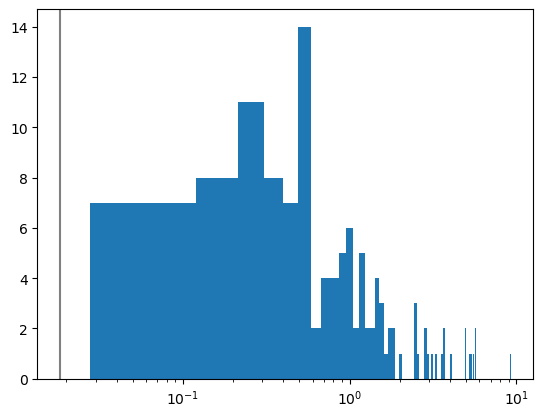

In [22]:
fitted_genes = fitted_genes[fitted_genes.isin(gene_name)]
fitted_idx = adata.var_names.isin(fitted_genes)

Ub_gene_idx = np.array([ np.where(gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes ])
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

/tmp/ipykernel_3284291/965276848.py:2: RuntimeWarning: divide by zero encountered in divide
  ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
/tmp/ipykernel_3284291/965276848.py:3: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
/tmp/ipykernel_3284291/965276848.py:7: RuntimeWarning: divide by zero encountered in divide
  ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
/tmp/ipykernel_3284291/965276848.py:8: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)


(4591, 122, 2)

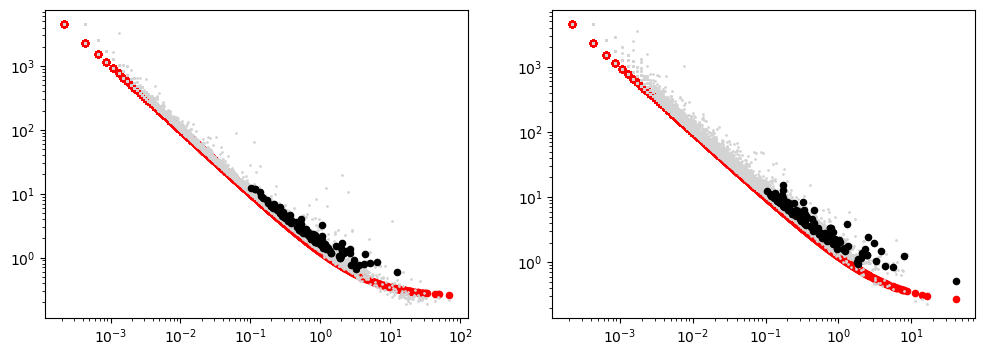

In [23]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
X_ATAC = adata.layers["atac"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

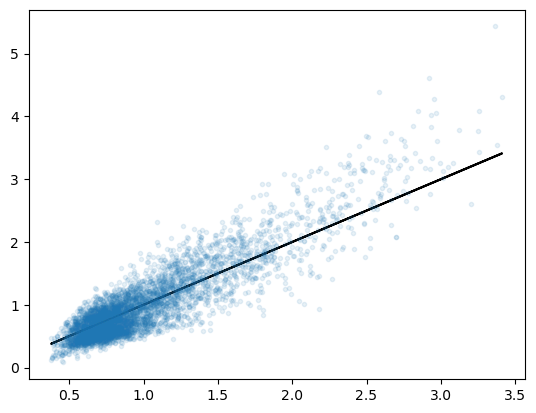

In [93]:
plt.plot(rd,rd,'k')
plt.plot(rd,X.mean((1,2))/X.mean(),'.',alpha=0.1)

In [24]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
if plot_idx.sum() == 0:
    plot_idx = np.arange(10)
else:
    print(fitted_genes[plot_idx])

Index(['KLF1', 'GATA2'], dtype='object', name='Gene')


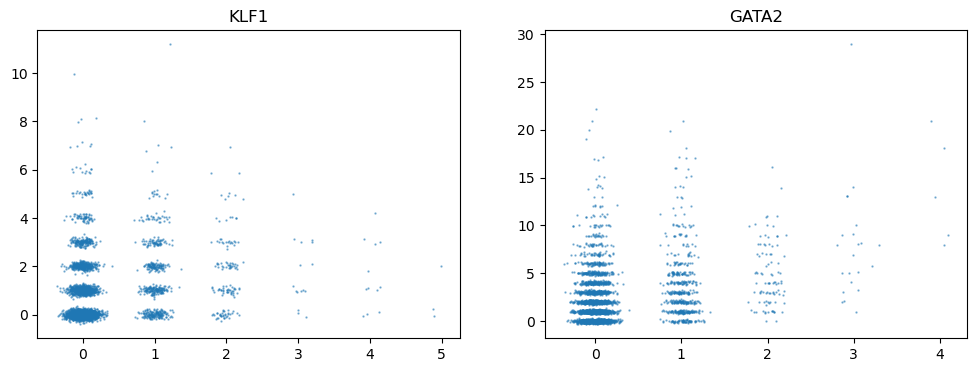

In [25]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

## Mixtures fitting

In [26]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

1 -279.552779929478 -279.60592739190446 -279.7768457285628
2 -265.5565179164792 -265.6630306588011 -266.0055678171041
3 -262.8287793567899 -262.98865737900724 -263.5028133589549
4 -260.7660501103946 -260.97929341250745 -261.6650682140997
5 -259.0404158992114 -259.3070244812197 -260.16441810445656
6 -257.70712788183926 -258.027101743743 -259.0561141886245


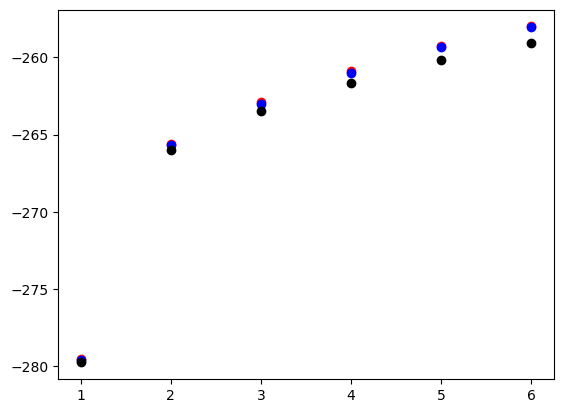

In [27]:
PMs = []
for nc in range(1,7):
    PM = PoissonMixture(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    plt.scatter(nc,elbo,color='r')
    plt.scatter(nc,PM.compute_AIC(X_mix),color='b')
    plt.scatter(nc,PM.compute_BIC(X_mix),color='k')
    print(nc,PM.compute_lower_bound(X_mix),PM.compute_AIC(X_mix),PM.compute_BIC(X_mix))

In [28]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)

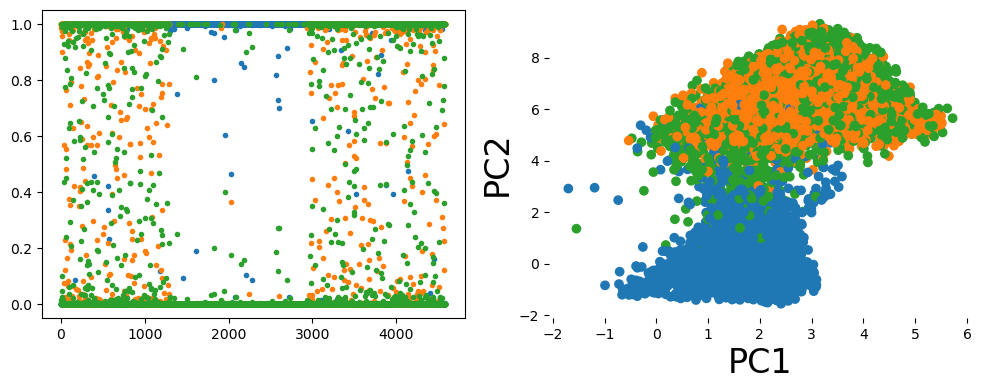

In [29]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x_umap[:,0],x_umap[:,1],c=tab_colors[np.argmax(Q,axis=1)]);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

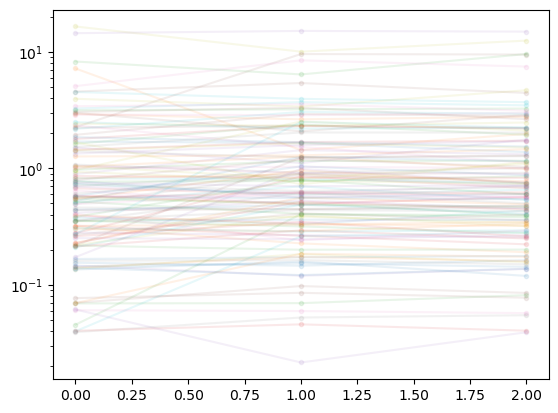

In [30]:
gbr = PM.theta[:,:,0]/PM.theta[:,:,1]

plt.plot(gbr,'.-',alpha=0.1);
plt.yscale('log')

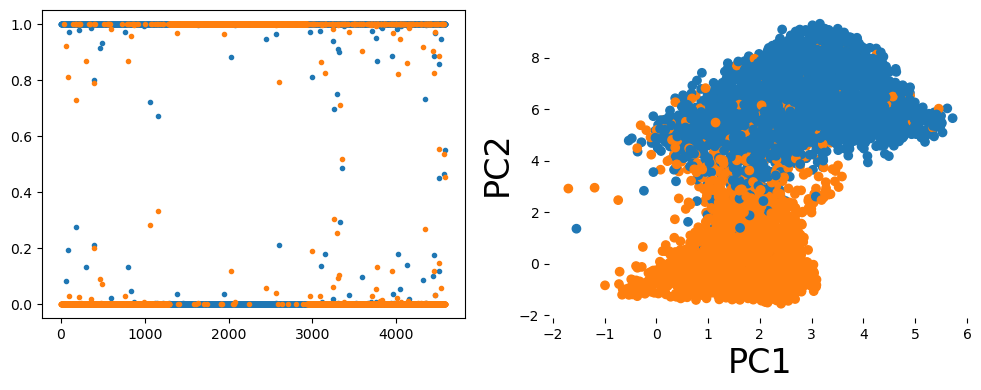

In [32]:
PM = PoissonMixture(n_components=2,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x_umap[cell_idx,0],x_umap[cell_idx,1],c=tab_colors[np.argmax(Q,axis=1)]);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

# Trajectory fitting

In [101]:
elbos = {}
traj_params={'r':X.mean((1,2))/X.mean(),"lambda_tau":0,"lambda_a":0}
traj_params_Ub={'r':rd,"Ub":Ub,"lambda_tau":0,"lambda_a":0}
x = x_umap

## Fine cluster

In [106]:
m=101
weight0 = np.ones((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    if i == 0:
        weight0[idx,0] += 100
    else:
        weight0[idx,int((i-1)*m/2):int(i*m/2)] += 2
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

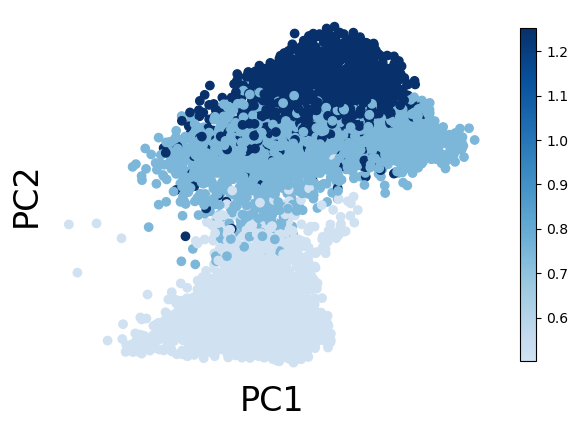

In [107]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=Q0[:,0]@np.linspace(0,2,m).reshape((-1,1)),cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [108]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=Q0,parallel=True,n_threads=10,epoch=100)
print(traj.elbos[-1])
traj_ws = copy.deepcopy(traj)

fitting with warm start


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]

-257.28961677221724


In [109]:
topo = np.array([[0,1,2]])
tau = (0,1,2)
traj_Ub = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj_Ub = traj_Ub.fit(X,warm_start=True,fit_tau=True,params=traj_params_Ub,Q=Q0,parallel=True,n_threads=10,epoch=100)
print(traj_Ub.elbos[-1])
traj_ws_Ub = copy.deepcopy(traj_Ub)

fitting with warm start


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]

-263.20447388811806


In [184]:
traj_tau = Trajectory(traj.topo, traj.tau, model="two_species_ss_tau",verbose=1)
traj_tau = traj_tau.fit(X,warm_start=True,params=traj.params,Q=traj.Q.copy(),parallel=True,n_threads=10,epoch=10)
print(traj_tau.compute_AIC(X,standard=False))

fitting with warm start


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]

-260.554824676643


In [185]:
traj = traj_tau

[0.         0.98779839 2.        ]


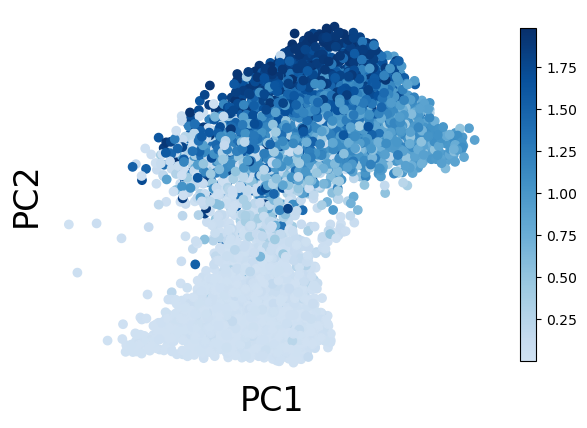

In [186]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x_umap[:,0],x_umap[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

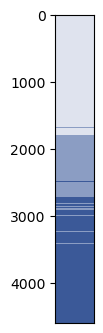

In [187]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

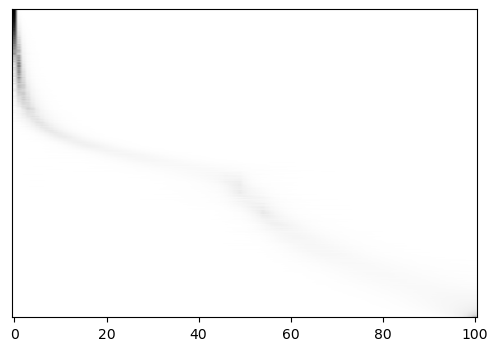

In [188]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

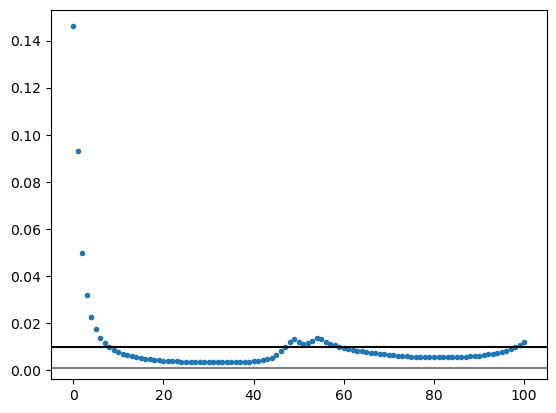

In [189]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

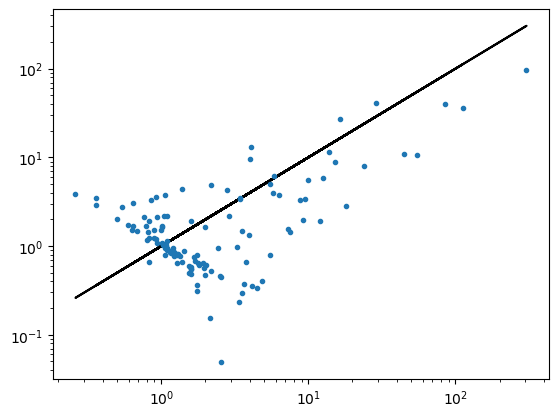

In [190]:
plt.loglog(traj.theta[:,[-2]],traj.theta[:,[-2]],'k');
plt.loglog(traj.theta[:,[-2]],traj.theta[:,[-1]],'.');

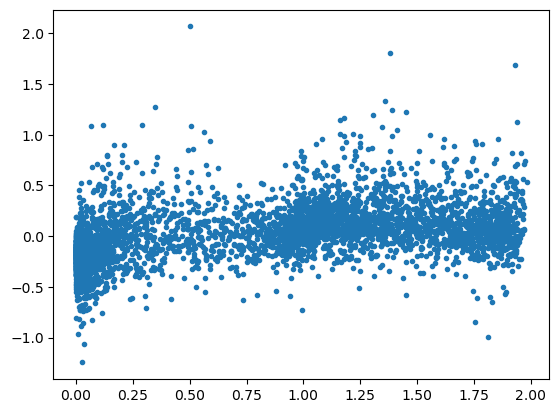

In [191]:
fig,ax = plt.subplots(1,1)
t_hat = traj.Q[:,0]@traj.t
cell_order = np.argsort(t_hat)
plt.plot(t_hat,X.mean((1,2))/X.mean()-rd,'.')

0.35856948045914416
0.10092462012828851 1.3005130172718689


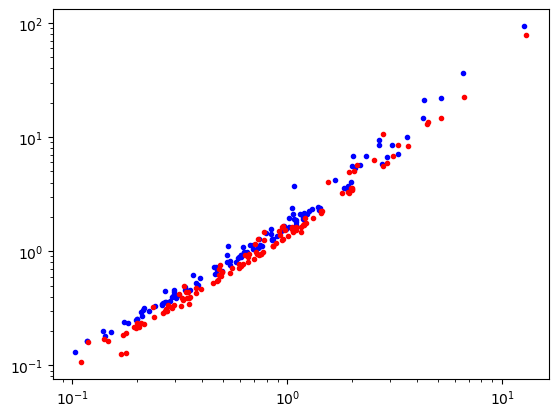

In [192]:
Y = traj.get_Y_hat(traj.theta, t_hat, traj.tau, traj.topo, traj.params)[0]
rd_s = traj.params['r'].var()/traj.params['r'].mean()**2
print(rd_s)
mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)
plt.loglog(mean,var,'b.')
plt.loglog(Y_mean,rd_s*mean**2+mean+(1+rd_s)*Y_var,'r.')
signal = Y_var
noise = var-rd_s*mean**2-(1+rd_s)*Y_var
unexplained = noise - mean
print((signal/mean).mean(),(noise/mean).mean())

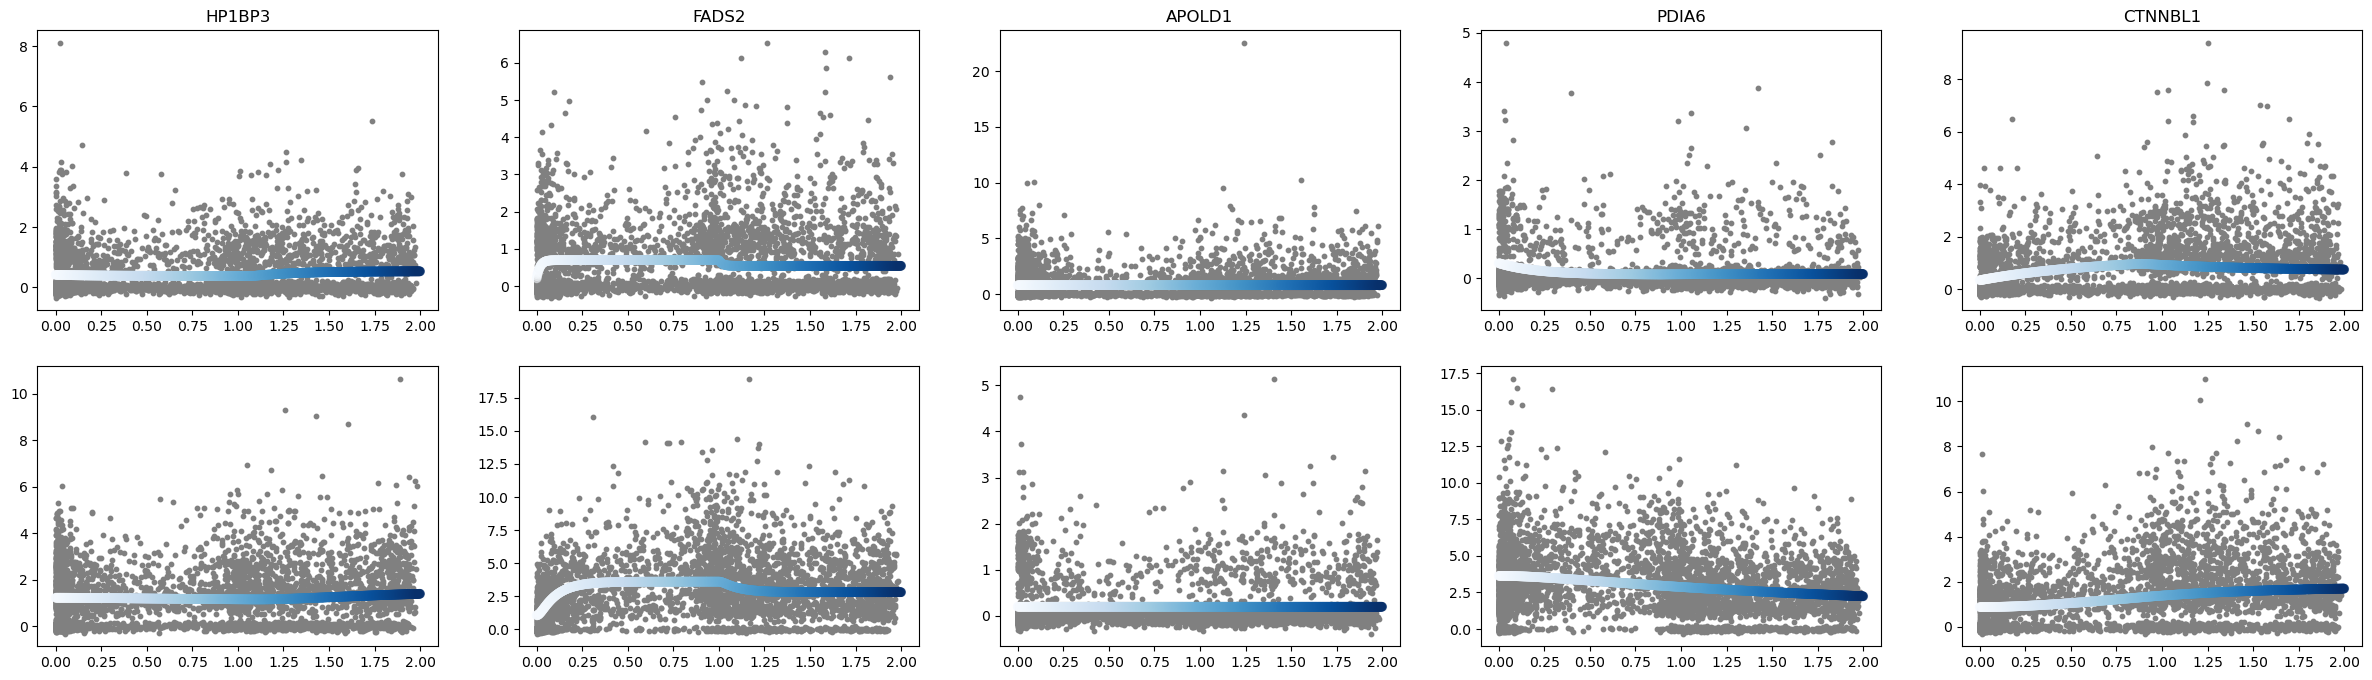

In [193]:
plot_y(traj,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

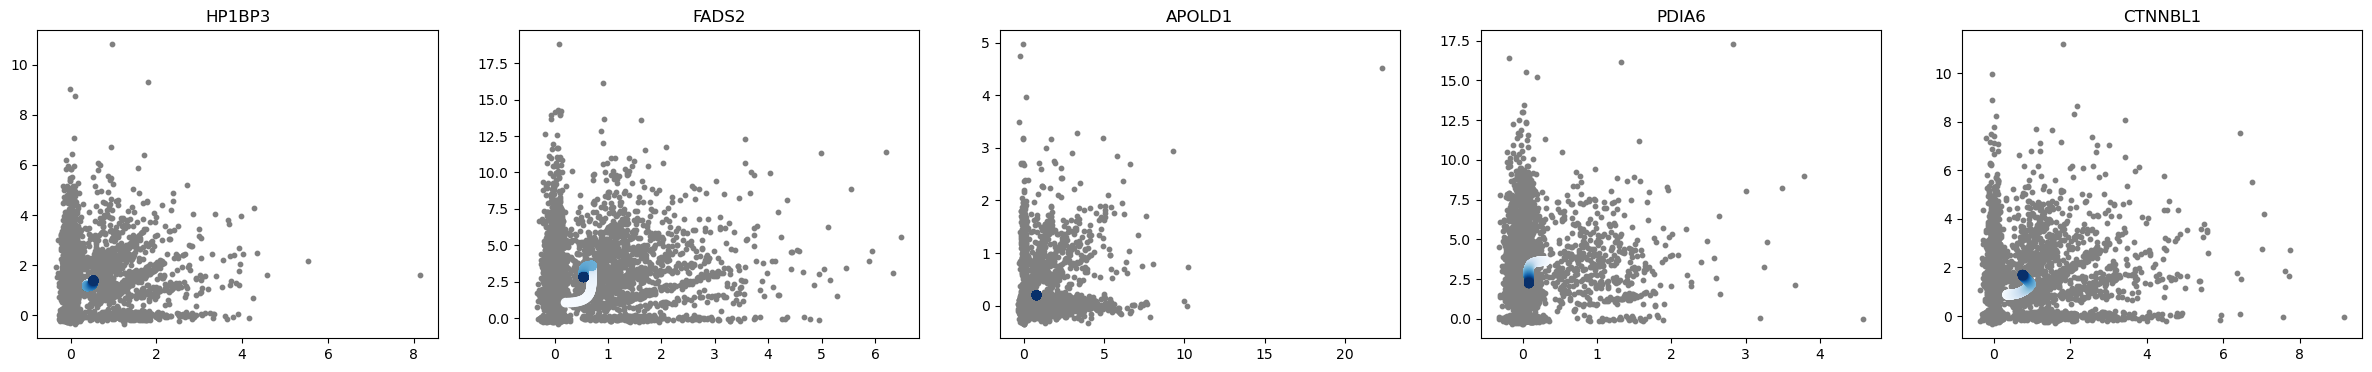

In [194]:
plot_phase(traj,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

[Text(0, 0, 'α0'), Text(1, 0, 'α1'), Text(2, 0, 'α2')]

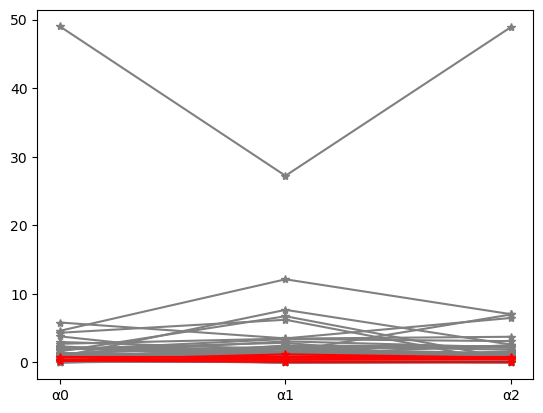

In [195]:
p=X.shape[1]
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

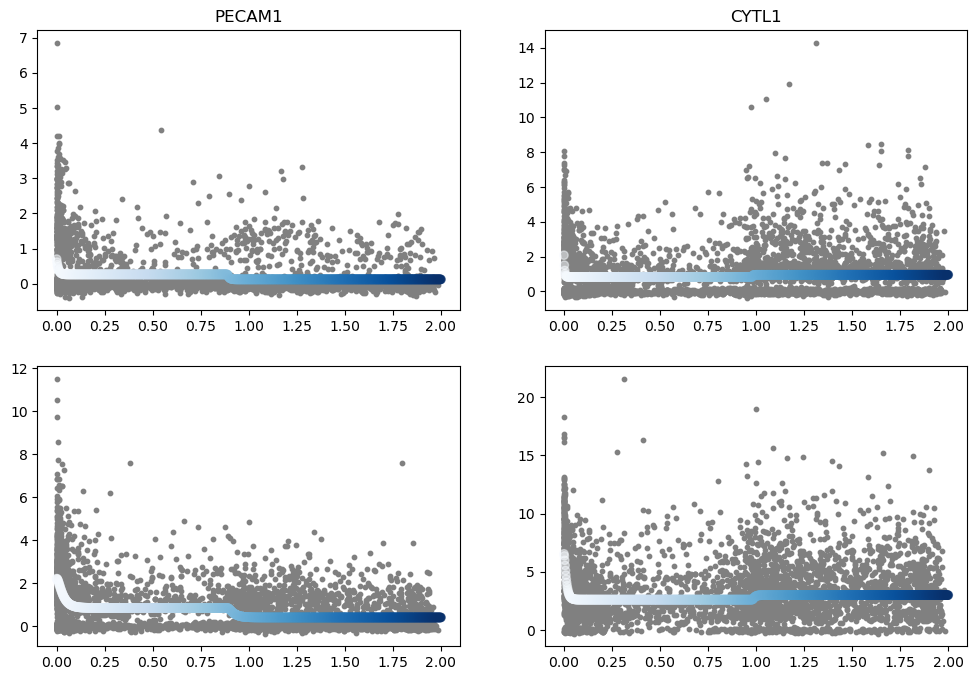

In [199]:
temp_plot_idx = np.where((traj.theta.max(1)-traj.theta.min(1))>10*np.sqrt(traj.theta.max(1)))[0]
plot_y(traj,X=X/rd[:,None,None],idx=temp_plot_idx,gene_name=fitted_genes);

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(array([ 2.,  3., 31., 40., 17., 11.,  7.,  2.,  5.,  3.]),
 array([-0.07295161, -0.02893377,  0.01508406,  0.0591019 ,  0.10311974,
         0.14713758,  0.19115541,  0.23517325,  0.27919109,  0.32320893,
         0.36722676]),
 <BarContainer object of 10 artists>)

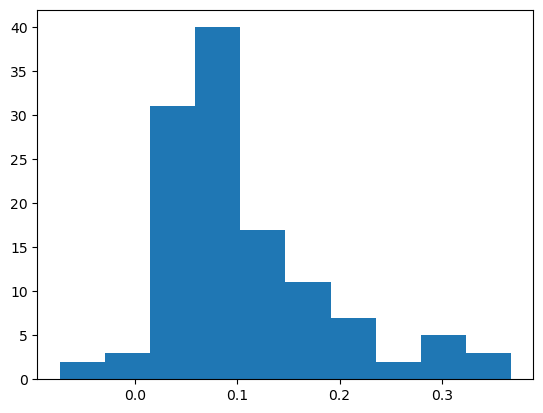

In [200]:
p = traj.theta.shape[0]
L,m = traj.Q.shape[1:]
alphas = np.zeros((p,m))

alphas[:,0] = traj.theta[:,0]
alphas[:,:int(traj.tau[1]/traj.tau[-1]*(m-1))] = traj.theta[:,1,None]
alphas[:,int(traj.tau[1]/traj.tau[-1]*(m-1)):] = traj.theta[:,2,None]

alpha_hat = traj.params['r'][:,None]*(traj.Q[:,0]@alphas.T)

atac_cor = np.zeros(p)
for j in range(p):
    atac_cor[j] = np.corrcoef(X_ATAC[:,j],alpha_hat[:,j])[0,1]
plt.hist(atac_cor)

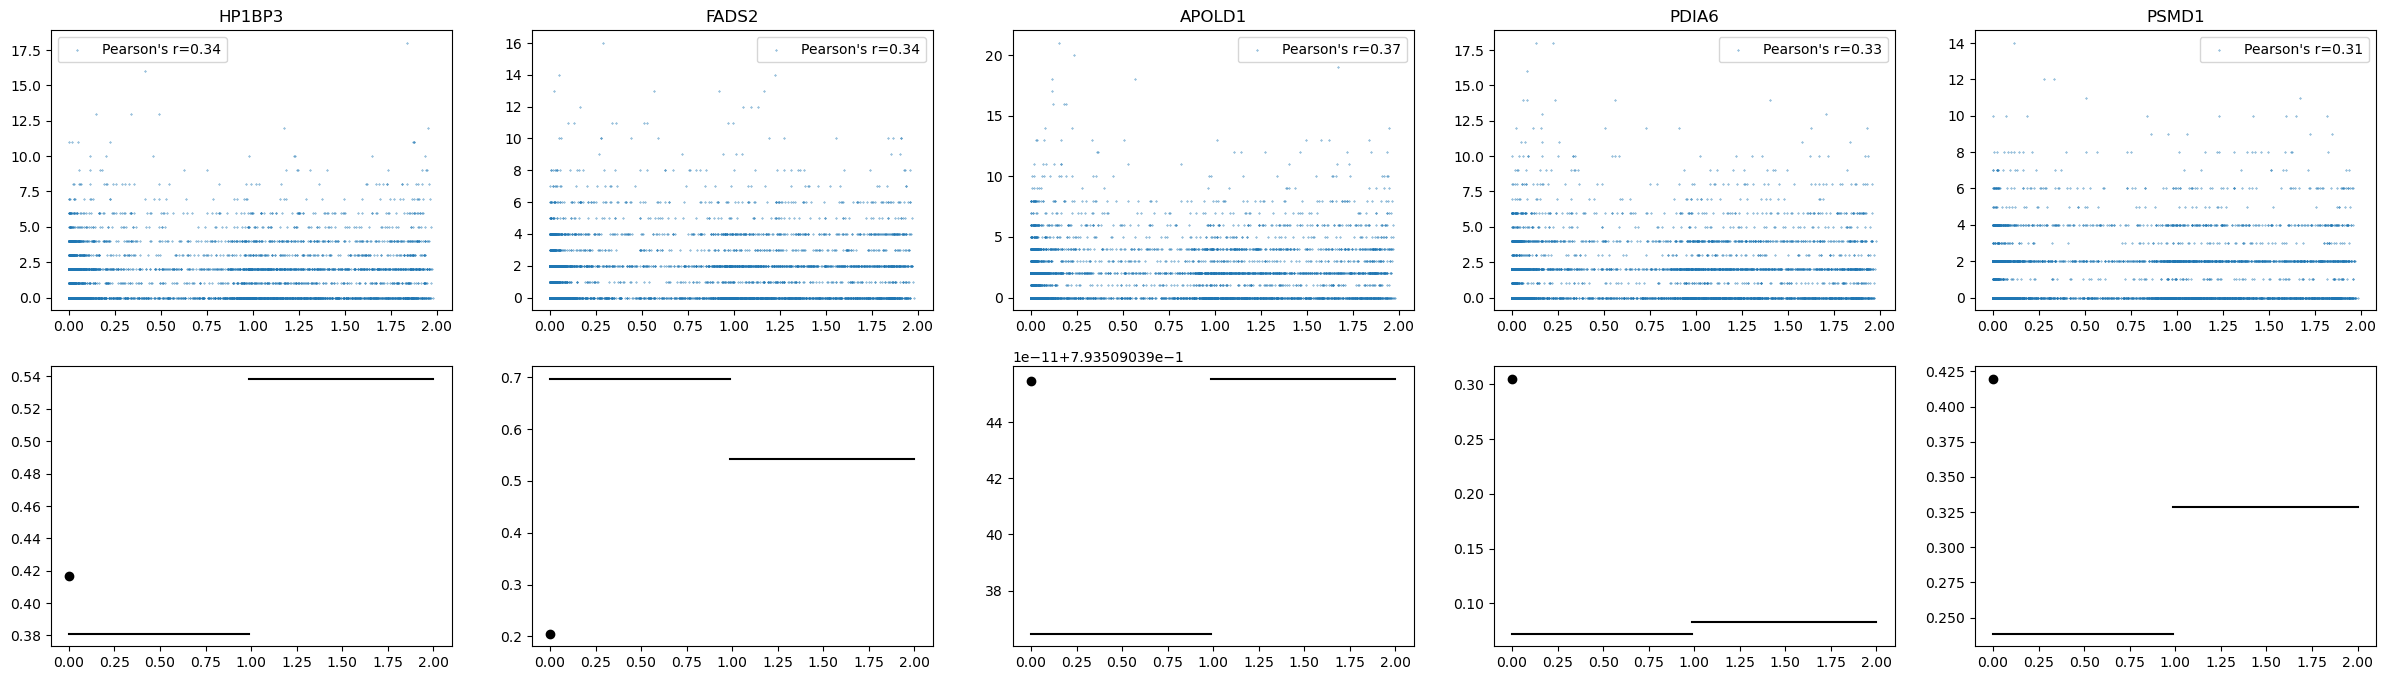

In [201]:
plot_idx = np.where(atac_cor>0.3)[0]

fig,ax = plt.subplots(2,len(plot_idx),figsize=(6*len(plot_idx),8))
K = len(tau)-1
t_hat = traj.Q[:,0]@traj.t
cell_order = np.argsort(t_hat)
x = t_hat[cell_order]
for i,j in enumerate(plot_idx):
    gene = fitted_genes[j]
    y = X_ATAC[cell_order,j]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(x,y,s=0.1,label="Pearson's r="+str(np.round(np.corrcoef(y,atac_hat[cell_order,j])[0,1],2)));
    ax[0,i].legend()
    for k in range(K):
        ax[1,i].plot([traj.tau[k],traj.tau[k+1]],[traj.theta[j,k+1]]*2,c='k')
    ax[1,i].scatter(0,traj.theta[j,0],color='k')
    ax[1,i].set_xlim((traj.tau[0]-0.1,traj.tau[-1]+0.1))

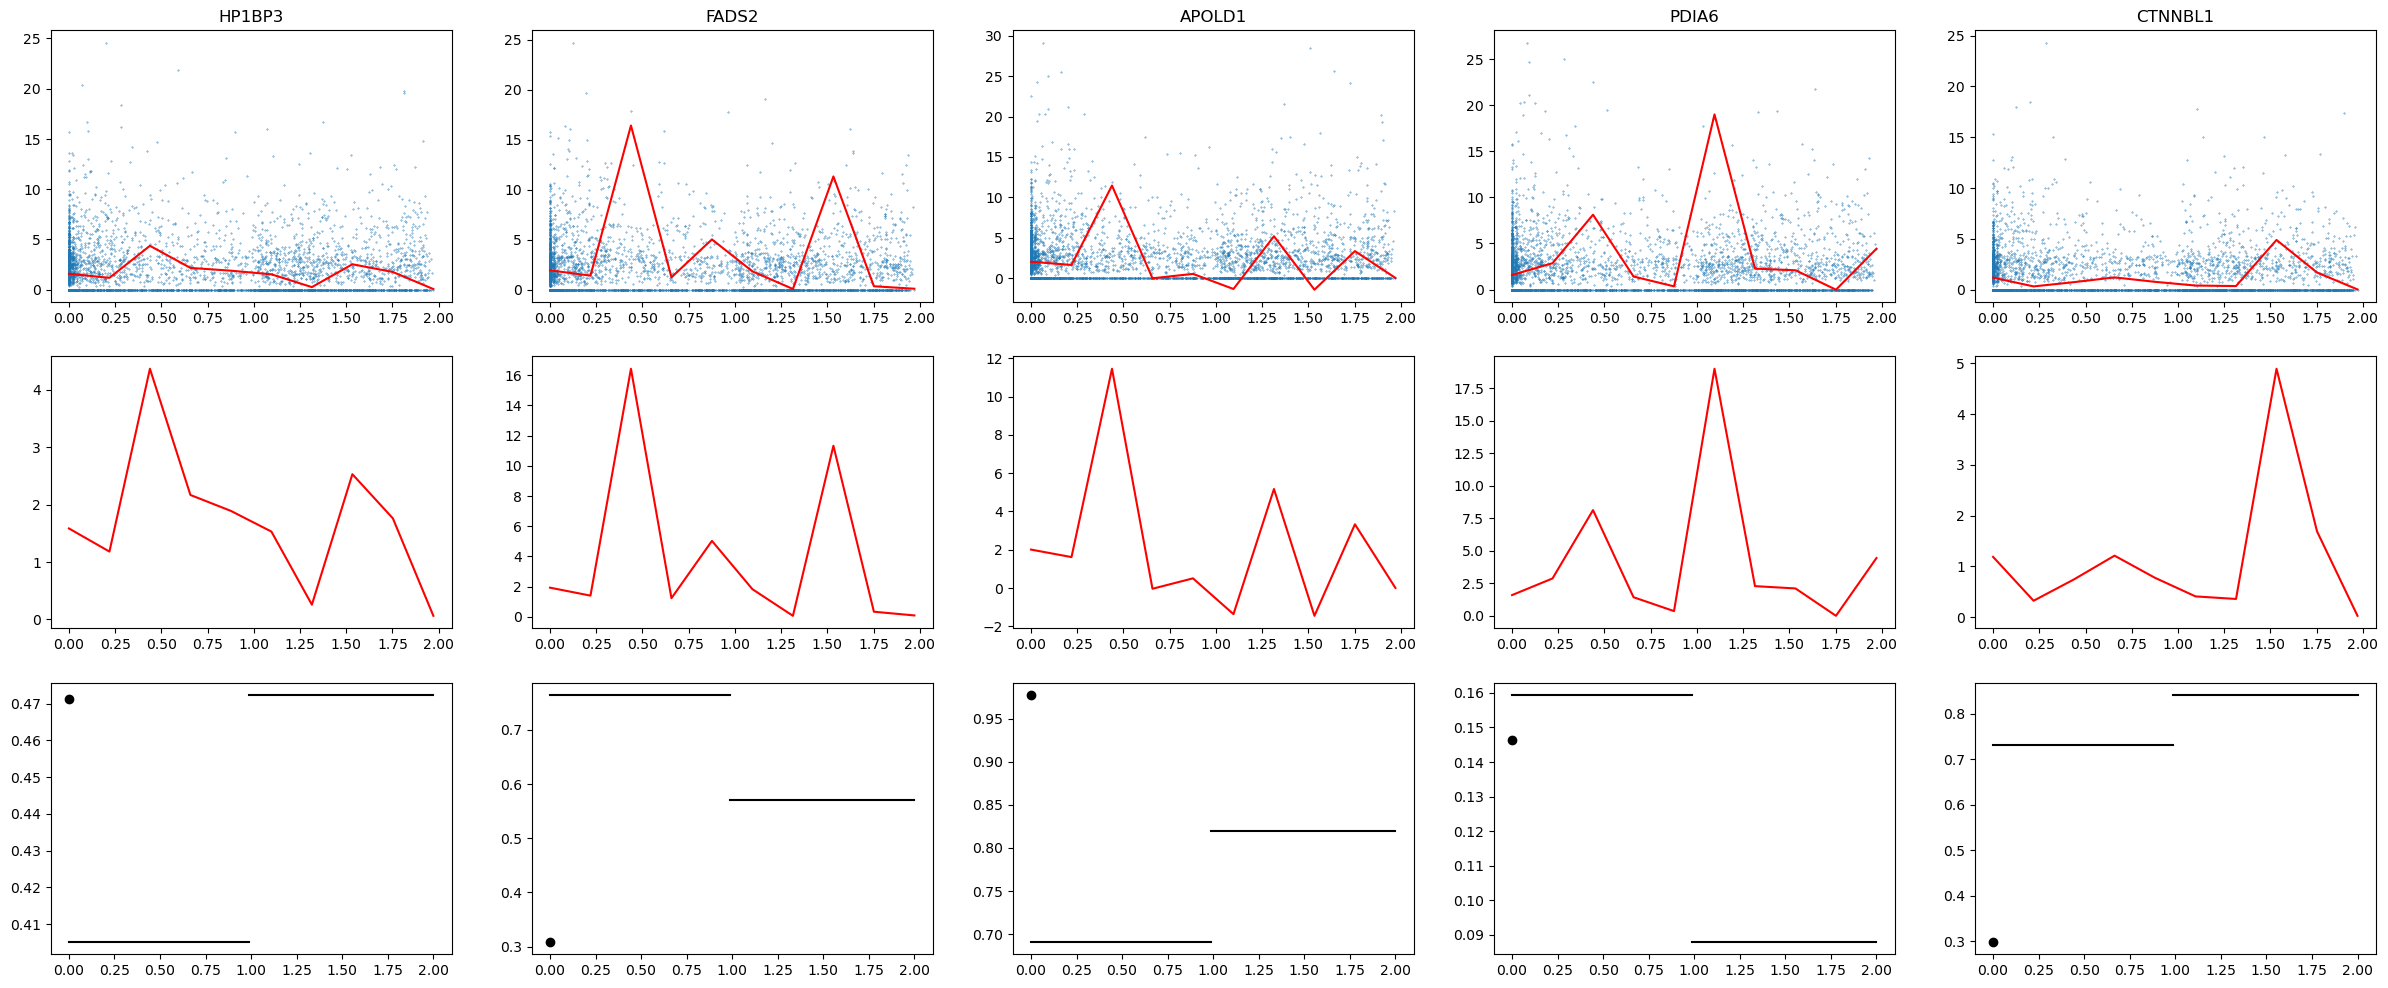

In [181]:
from scipy.interpolate import UnivariateSpline

fig,ax = plt.subplots(3,len(plot_idx),figsize=(6*len(plot_idx),12))
K = len(tau)-1
t_hat = traj.Q[:,0]@traj.t
cell_order = np.argsort(t_hat)
x = t_hat[cell_order]
x_smooth = np.linspace(x.min(), x.max(), num=10)  # Generate a uniform grid for plotting
for i,j in enumerate(plot_idx):
    gene = fitted_genes[j]
    ax[0,i].set_title(gene)
    y = X_ATAC[cell_order,j]/rd
    spline = UnivariateSpline(x, y, s=3*len(x))
    y_smooth = spline(x_smooth)
    ax[0,i].scatter(x,y,s=0.1)
    ax[0,i].plot(x_smooth, y_smooth, label='Smoothed Function',c='r')
    ax[1,i].plot(x_smooth, y_smooth, label='Smoothed Function',c='r')
    for k in range(K):
        ax[2,i].plot([traj.tau[k],traj.tau[k+1]],[traj.theta[j,k+1]]*2,c='k')
    ax[2,i].scatter(0,traj.theta[j,0],color='k')
    ax[2,i].set_xlim((traj.tau[0]-0.1,traj.tau[-1]+0.1))

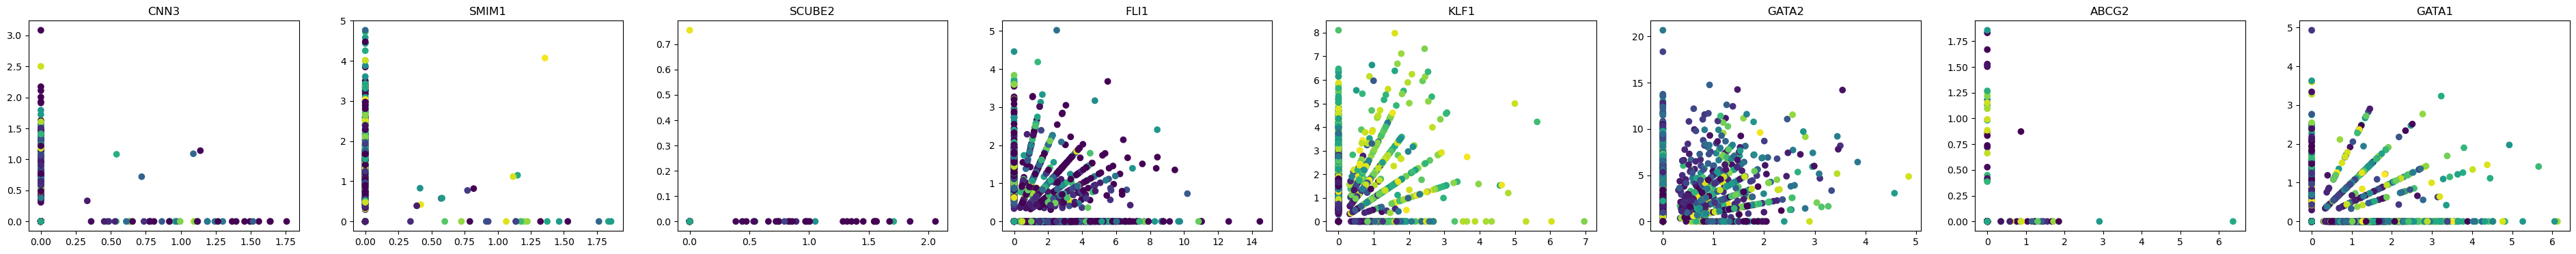

In [182]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

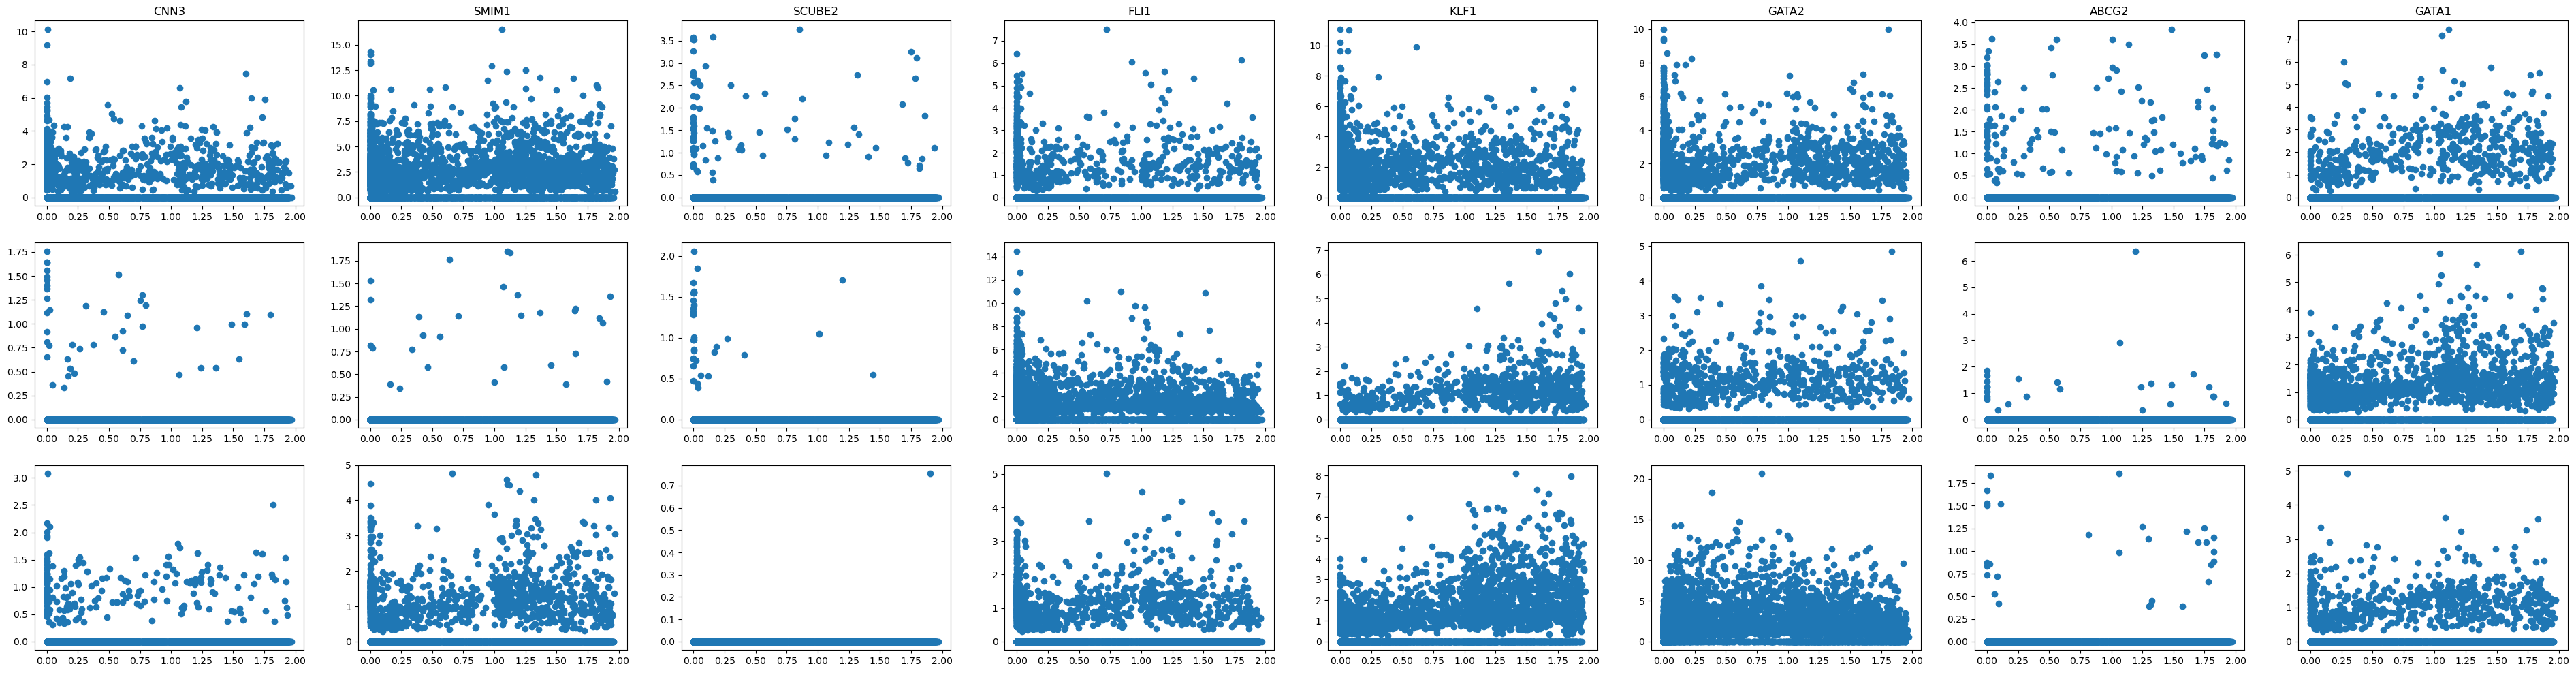

In [183]:
fig,ax = plt.subplots(3,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),12))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["atac"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[2,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

In [239]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

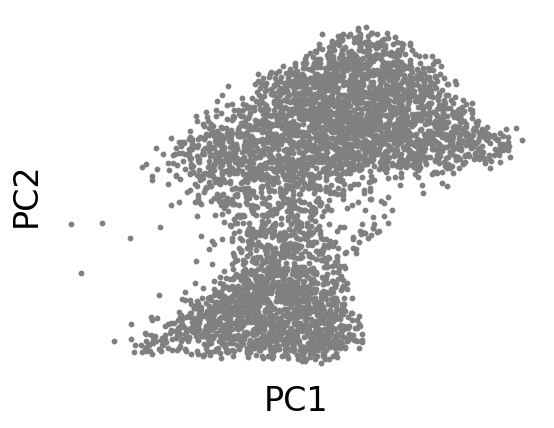

In [165]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x_umap[:,0],x_umap[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [95]:
from multiprocessing import Pool

tau = (0,1,2)
topo = np.array([[0,1,2]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,fit_tau=True,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

/tmp/ipykernel_977772/3120039309.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')


Text(0.5, 1.0, 'Random initialiazation')

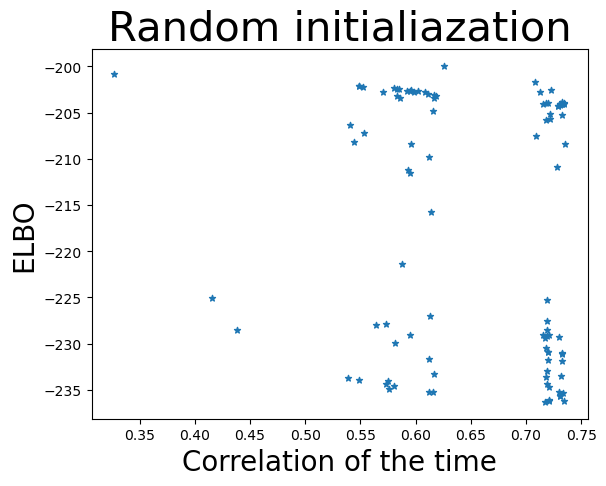

In [96]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [97]:
traj = trajs[np.argmax(elbos)]
np.max(elbos)

-199.95376670879543

[0.         0.79937829 2.        ]


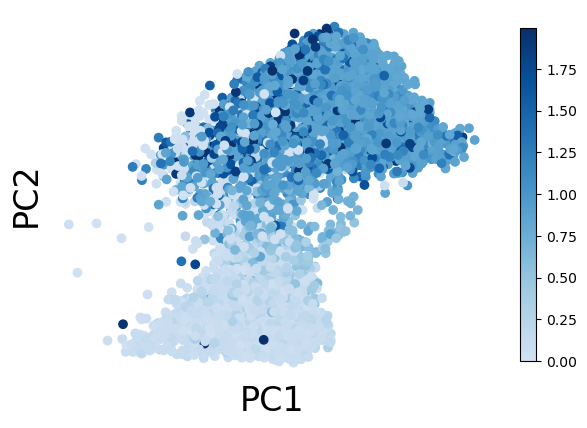

In [98]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

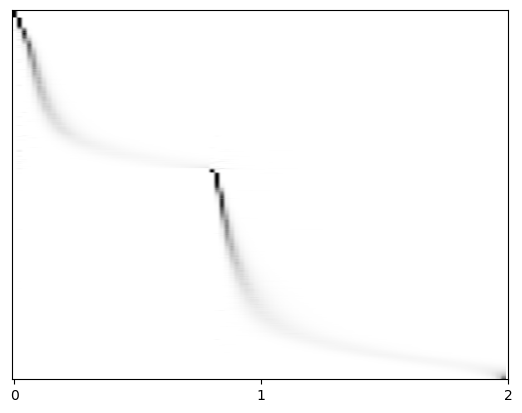

In [99]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

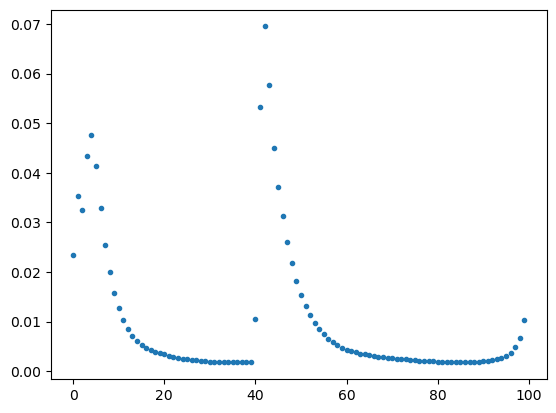

In [100]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')

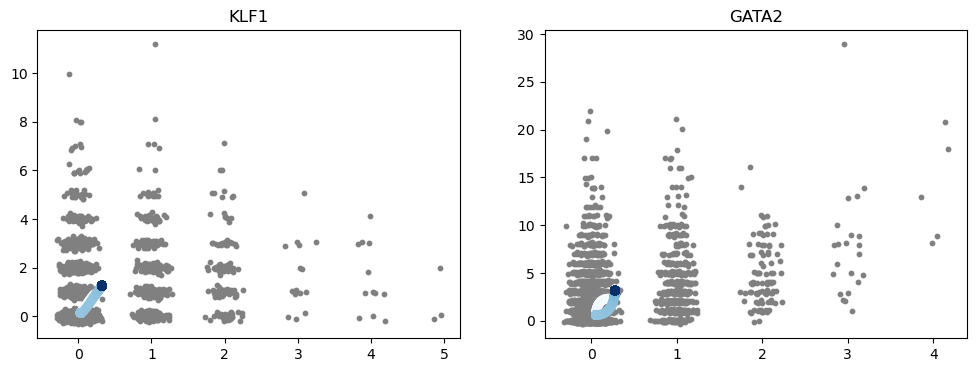

In [101]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

4


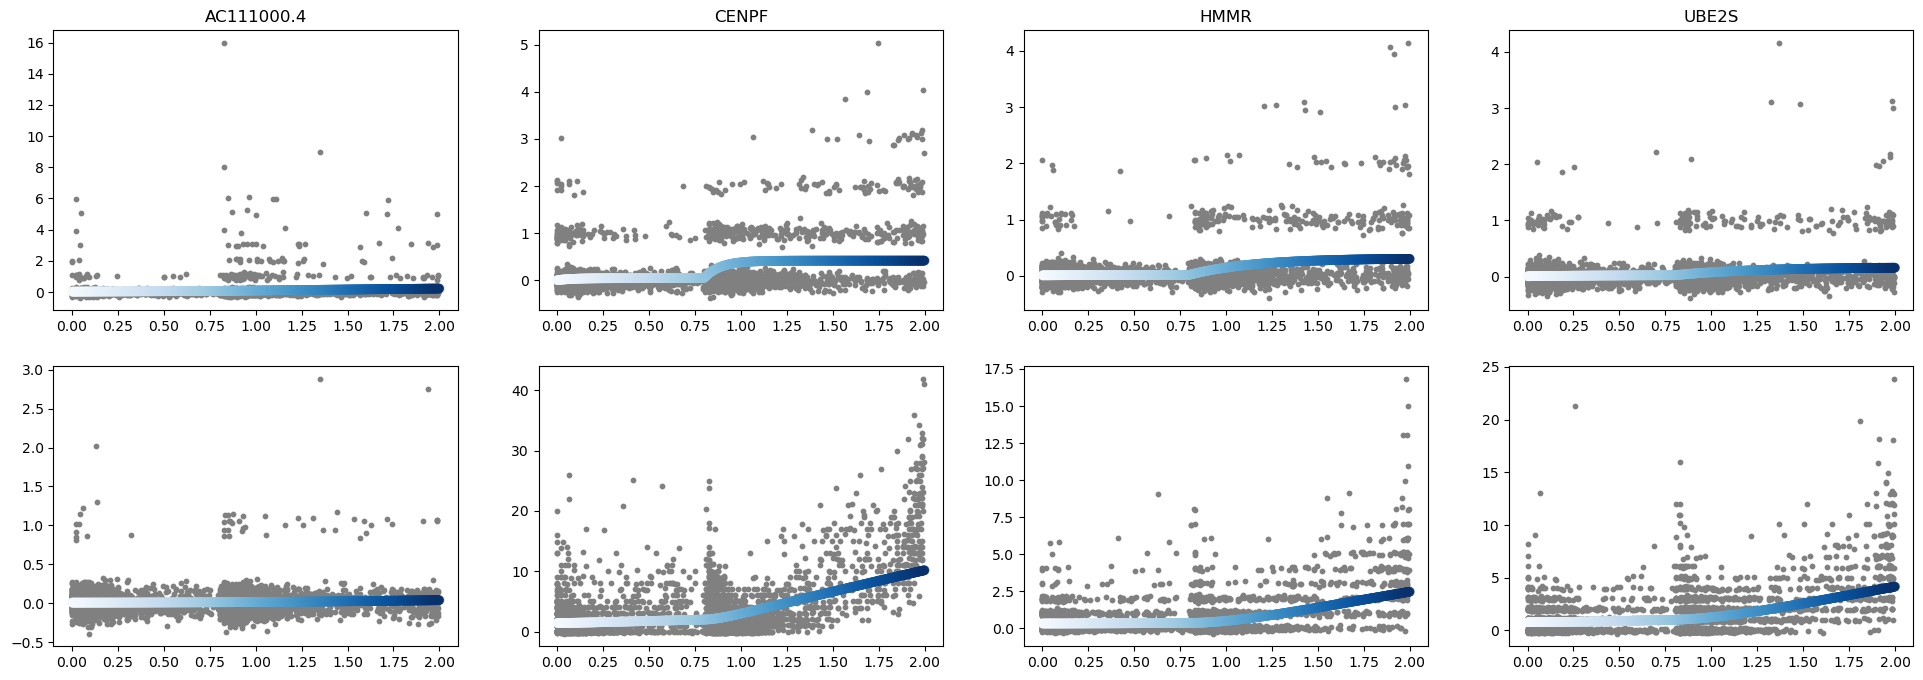

In [102]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

### two_species_ss_tau

In [228]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
Input_args = []

def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss_tau", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

100%|██████████| 20/20 [20:21<00:00, 61.06s/it]


Text(0.5, 1.0, 'Random initialiazation')

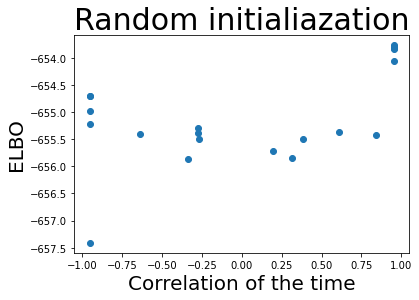

In [229]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [235]:
traj = trajs[np.argmax(elbos)]

(array([171.,   4.,  17.,  12.,  18.,  34.,   9.,  23.,   9., 196.]),
 array([23.5, 23.6, 23.7, 23.8, 23.9, 24. , 24.1, 24.2, 24.3, 24.4, 24.5]),
 <BarContainer object of 10 artists>)

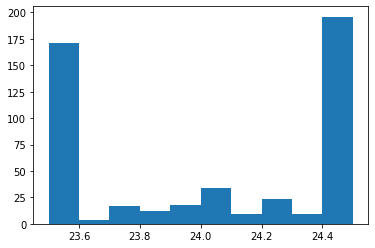

In [236]:
plt.hist(traj.theta[:,-3])

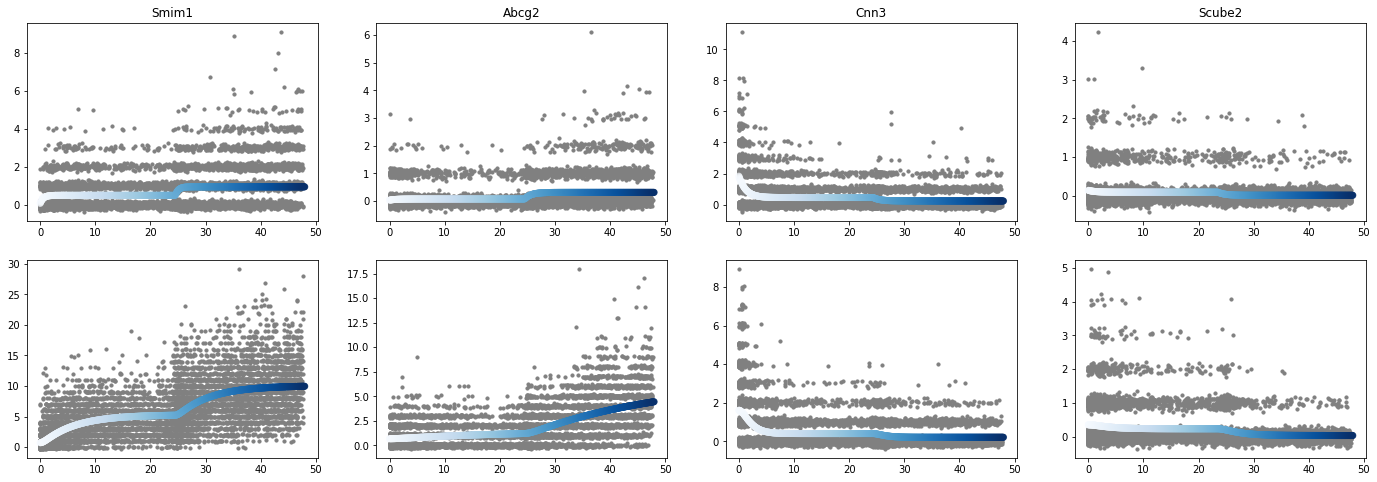

In [237]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

### two_species

In [242]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

100%|██████████| 100/100 [2:02:24<00:00, 73.45s/it] 


Text(0.5, 1.0, 'Random initialiazation')

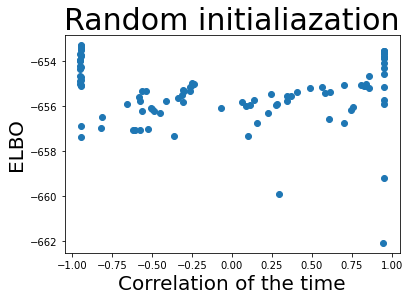

In [243]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [257]:
traj = trajs[np.argmax(elbos)]
traj.elbos[0][-1]

-653.2902129127483

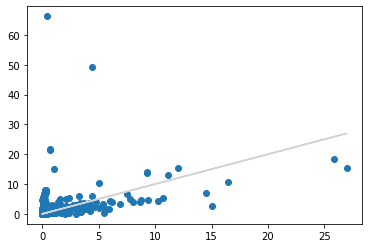

In [258]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

In [259]:
traj = trajs[np.argmax(corrs)]
traj.elbos[0][-1]

-654.0742261573195

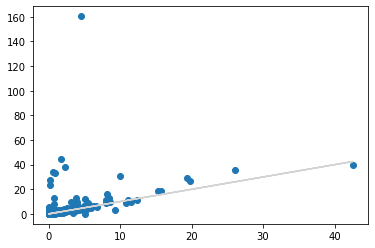

In [256]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

## Synthetic data

In [299]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=Q0,parallel=True,n_threads=4,epoch=10)

fitting with warm start


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


In [301]:
print(traj.elbos[-1])

-658.4752472018502


[ 0.         23.94425778 48.        ]


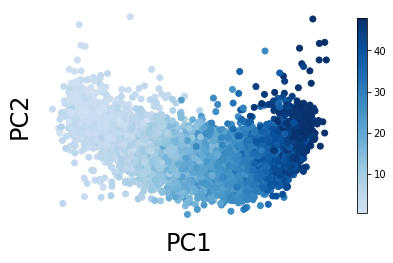

In [300]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

<AxesSubplot:>

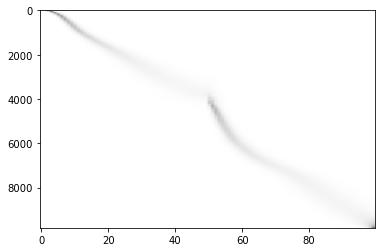

In [302]:
plot_t(traj,order_cells=True)

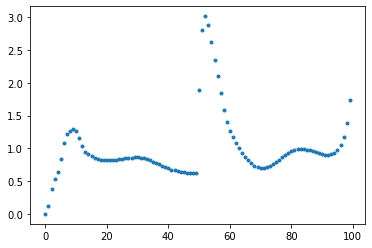

In [303]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

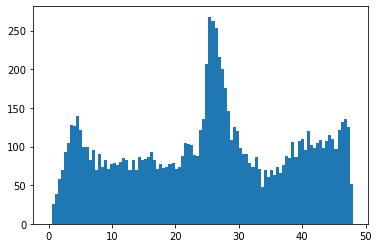

In [304]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

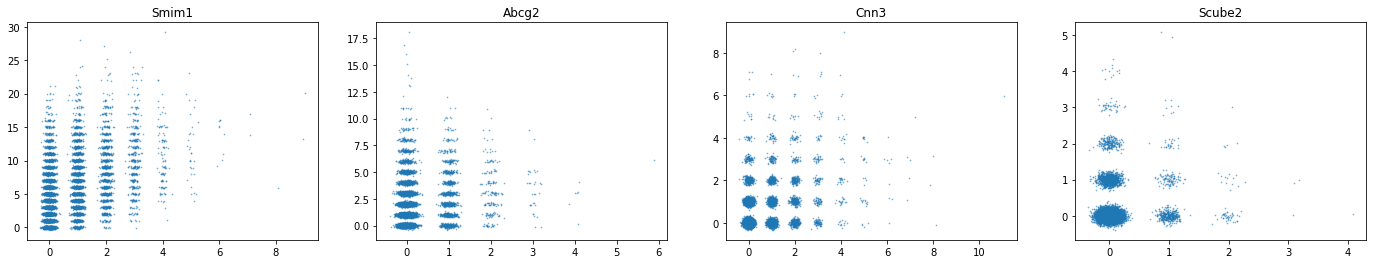

In [307]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [309]:
syn_tau = traj.tau.copy()
syn_topo = traj.topo.copy()

Input_args = []
def fit_wrapper(seed):
    syn_traj = Trajectory(syn_topo, syn_tau, model="two_species_ss", verbose=0)
    syn_traj = syn_traj.fit(syn_X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return syn_traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    syn_trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

100%|██████████| 20/20 [12:44<00:00, 38.21s/it]


Text(0.5, 1.0, 'Random initialiazation')

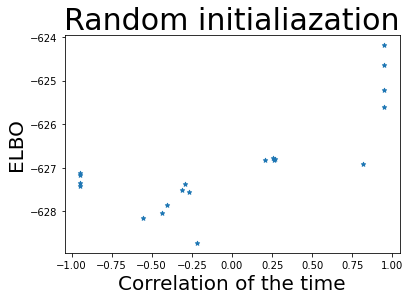

In [310]:
corrs = []
elbos = []
for syn_traj in syn_trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)